# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
#import numpy as np
import numpy
import pickle
import matplotlib.pyplot as plt

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from pytket.extensions.qulacs import QulacsBackend
from pytket.extensions.cirq import CirqStateSampleBackend

backend = None

from discopy.quantum import Circuit
from discopy.tensor import Tensor

from utils import read_diagrams, create_labeled_classes, loss, acc

import jax
from jax import jit
from noisyopt import minimizeSPSA

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

## Read circuit data

We read the circuits from the pickled files.

In [2]:
# Select workload
workload = "small"
#workload = "medium"
#workload = "large"

# Select if we perform binary classification or multi-class classification
# Give number of qubits to create classes:
# 1 -> 2^1 = 2 classes i.e. binary classification
# 2 -> 2^2 = 4 classes
# ...
# 5 -> 2^5 = 32 classes, etc.

classification = 2

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//circuits//" + str(classification) + "//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Lambeq optimizer

In [5]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Total number of circuits:  29
Total number of variables:  77


In [6]:
training_data_labels_l = np.array(training_data_labels_l)
test_data_labels_l = np.array(test_data_labels_l)
validation_data_labels_l = np.array(validation_data_labels_l)

## Model

In [7]:
parameters = sorted(
    train_syms,
    key=default_sort_key)

In [8]:
def make_pred_fn(circuits):
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

train_pred_fn = jit(make_pred_fn(training_circuits_l))
dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
test_pred_fn = make_pred_fn(test_circuits_l)

## Loss function and evaluation

In [9]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Trainer

In [10]:
EPOCHS = 20000
SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

import numpy

rng = numpy.random.default_rng(SEED)
init_params_spsa = np.array(rng.random(len(parameters)))
numpy.random.seed(SEED)

#print(jax.make_jaxpr(train_pred_fn)(init_params_spsa))

train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

def callback_fn(xk):
    #cost_val = train_cost_fn(xk, costs = cost_store_spsa, accuracies = acc_store_spsa)
    cost_val = train_costs[-1]
    acc_val = train_accs[-1]
    iters = len(train_accs)/2
    if iters % 100 == 0:
        print(
                #f"Params = {xk}, "
                f"Iteration = {iters}, "
                f"Cost = {cost_val}",
                f"Accuracy on training data = {acc_val}"
            )

In [11]:
result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = 1.5, c = 0.2, niter=EPOCHS, callback=dev_cost_fn)
print(result)

     fun: 0.19145796487205907
 message: 'terminated after reaching max number of iterations'
    nfev: 40000
     nit: 20000
 success: True
       x: DeviceArray([0.59816104, 0.2501129 , 0.24041262, ..., 0.40338868,
             0.39544433, 0.93857783], dtype=float32)


Test accuracy: 0.375


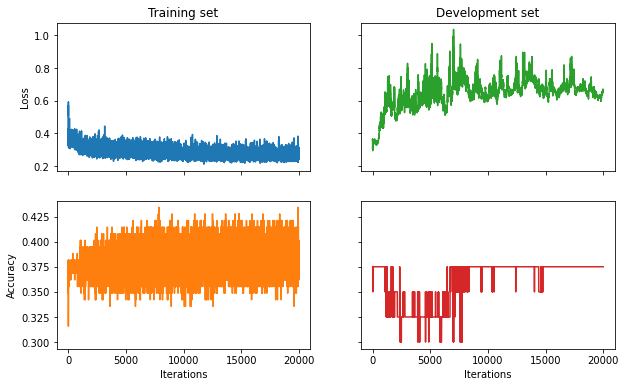

In [12]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_data_labels_l)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])